# Udacity - Capstone Project

# Project - Invasive Species

## In this Project, we are going to work on a problem of identifying Invasive species amongst all the species available.

### This is part of Kaggle competition projects on Invasive Species,
###    There is a lot of researchers human effort indulged every year in identifying the invasive species amongst all the species which are helpful for the environment and plant growth. This is really an important problem as saving plants from invasive species not only saves the plants but also the humans from intaking from those environment. As we are heading to the new generation technologies, we need to find an automated solution to replace valuable researchers time in finding solutions to much bigger problems rather spending on finding the invasive species among all the other species in a huge farm/any place, as this is very time consuming and inefficient for their time.
###    So we want to solve this problem by identifying the invasive species among other by developing a image classification model. We would like to try/use different algorithms to develop image classification prediction model, which can identify the invasive species with a very good accuracy which can be relied and with minimal human intervention. Further, we would like to deploy this model on a aerial viewer like a quadcopter to move around farm lands with a deployed image classifier to identify the location of invasive species with minimal time, which will save time, cost , especially life of plants from further damage.

###### The Road Ahead

###### We break the notebook into separate steps. Feel free to use the links below to navigate the notebook.
###### Step 1: Import Datasets
###### Step 2: Preprocess the Images
###### Step 3: Create a CNN Model and Train the Model
###### Step 4: Import a Pretrained Network
###### Step 5:Write the Custom Model using Transfer Learning
###### Step 6:  Test the Model and store the results on Test Set

Importing the libraries is one of the key thing we need to do, let's do it starting with some basic library requirements

In [167]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
import pandas as pd
from glob import glob
import random
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image                  
from tqdm import tqdm
from keras.applications.resnet50 import preprocess_input, decode_predictions
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 
import os

Lets, Now load the labels to see the count of training and testing labels.
Training labels are provided in the csv file and a sample of submission file is provided as a csv, lets
load them and drop if NA(Empty) values exist and see the count

In [168]:
train_labels = pd.read_csv("/invasive-species/train_labels.csv")
sample_submission = pd.read_csv("/invasive-species/sample_submission.csv")

train_labels.dropna
train_labels.tail()

sample_submission.dropna
sample_submission.tail()

print('There are %d total training images.' % len(train_labels))
print('There are %d total testing images.' % len(sample_submission))

There are 2295 total training images.
There are 1531 total testing images.


Lets look at a few image visuals

In [262]:
import matplotlib.image as mpatImg
def species_images(img_path):
    imgPrnt = mpatImg.imread(img_path)
    plt.figure(figsize=(10,10))
    plt.imshow(imgPrnt)

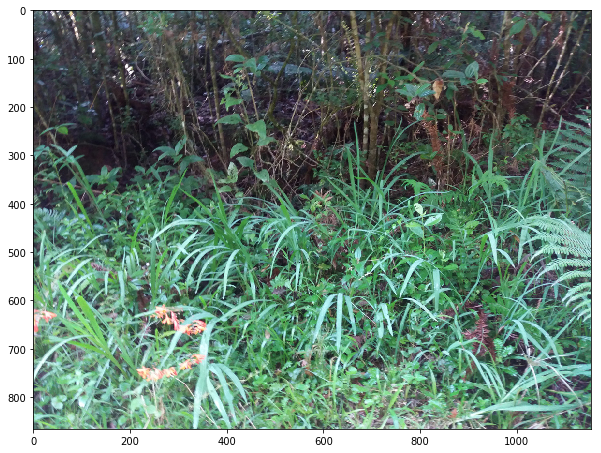

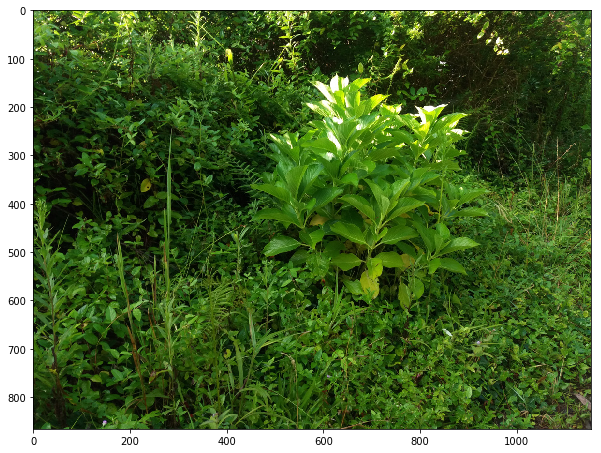

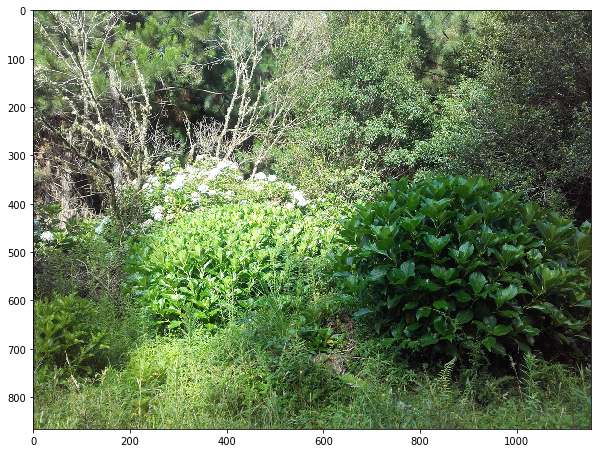

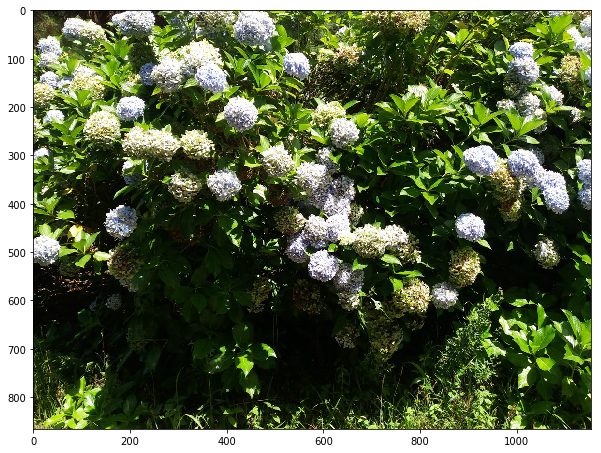

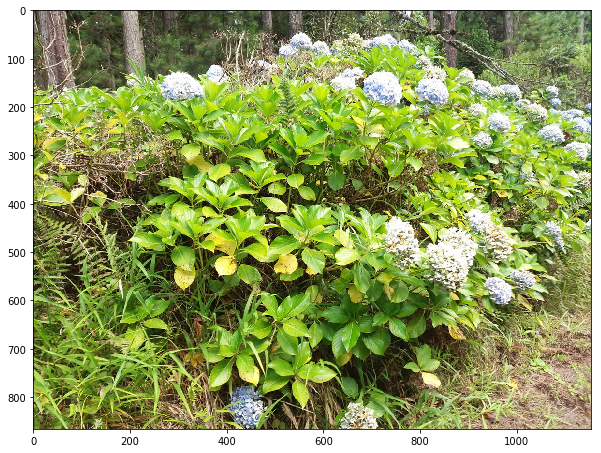

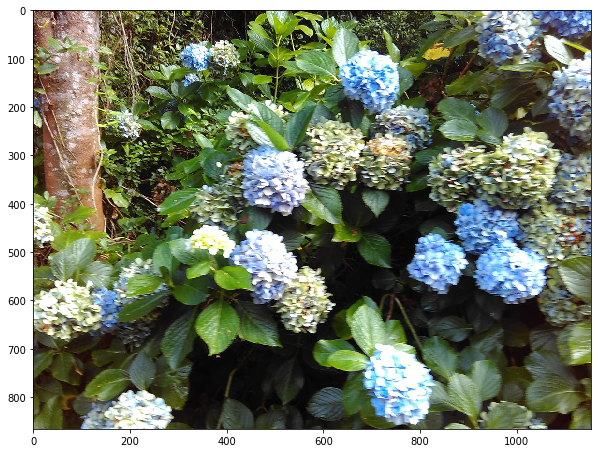

In [264]:
species_images('/invasive-species/train/1.jpg')
species_images('/invasive-species/train/29.jpg')
species_images('/invasive-species/train/298.jpg')
species_images('/invasive-species/train/1008.jpg')
species_images('/invasive-species/train/1987.jpg')
species_images('/invasive-species/train/2287.jpg')

Lets now preprocess the training and Testing Images and get them all to an array of images using the labels of the training and testing images

In [169]:
img_path = "/invasive-species/train/"

print(img_path)

y = []
file_paths = []
for i in range(len(train_labels)):
    file_paths.append( img_path + str(train_labels.iloc[i][0]) +'.jpg' )
    y.append(train_labels.iloc[i][1])
y = np.array(y)

/invasive-species/train/


We now resize all the images of training set to make sure all of the images are of the same size, so that the training of the model is consistent with out any issues
Initially lets define a function to center all the image pixels and then use open cv to read the images to common size as acceptable by our models

In [170]:
def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

In [171]:
x = []
for i, file_path in enumerate(file_paths):
    #read image
    img = cv2.imread(file_path)
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #resize
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))

    #centering
    img = centering_image(cv2.resize(img, dsize=tile_size))
    
    #out put 224*224px 
    img = img[16:240, 16:240]
    x.append(img)

x = np.array(x)

Now, Lets do the same process for test images ,
for the test images lets make the use of the sample submission.csv already available and store them as a numpy array of equal size

In [172]:
img_path = "/invasive-species/test/"

test_names = []
file_paths = []

for i in range(len(sample_submission)):
    test_names.append(sample_submission.ix[i][0])
    file_paths.append( img_path + str(int(sample_submission.ix[i][0])) +'.jpg' )
    
test_names = np.array(test_names)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


In [173]:
test_images = []
for file_path in file_paths:
    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #resize
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))

    #centering
    img = centering_image(cv2.resize(img, dsize=tile_size))
    
    #out put 224*224px 
    img = img[16:240, 16:240]
    test_images.append(img)
    
    path, ext = os.path.splitext( os.path.basename(file_paths[0]) )

test_images = np.array(test_images)

Before, we decide that the data is ready for training, 
lets randomize/shuffle the data, so that there is a random distribution of the images across the dataset
Lets use numpy library function random for this using permutation of the data for training and shuffle and store them in x and y as numpy shuffled array

In [174]:
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(x[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)

Now, we are further close to training ,

One last step,

Before the step, when we start training on the whole dataset and test on the testing set, there is no chance of optimization and testing on the training set is a sin, So now comes our safeguard set i.e., Validation set,
This is a cross validation set to cross validate the training done and then based on the cross validation accuracy which is not at all a part of the training set, we can estimate our test accuracy.
By the way, testing on the training set itself leads to biggest problem Overfitting.
Randomization and Shuffling is also used to mitigate the risk of overfitting.
We should always make sure to be away from overfitting, So we are dividing our training set to two parts, one is Training set and the other cross validation set.

Usually we use 80% of the shuffled training set as Training set and 20% for the cross validation set.

We are doing the same as below and assiging the training sets to x_train and x_test and cross validation sets to y_train adn y_test

In [175]:
val_split_num = int(round(0.2*len(y)))
x_train = x[val_split_num:]
y_train = y[val_split_num:]
x_test = x[:val_split_num]
y_test = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (1836, 224, 224, 3)
y_train (1836,)
x_test (459, 224, 224, 3)
y_test (459,)


Now, Lets Normalize the training data so that the range lies in between 0 and 1 .

Normalization will help us to remove distortions caused by lights and shadows in an image.

In [176]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

Now, its Time for us to create our own model using Neural Networks

lets use Convolution Neural Networks which work really good in image classification problems

Lets import the layers from the keras library

Our Model consists of input layer and three hidden layers and one output layer

For the input layer lets set the shape of input as its required and add as a Batch normalization to the shape of 224,224 and 3 dimensions of the image.

For the First hidden layer, we will use conv2d layer by using hyper parameters as filters = 256 ,kernelsize = 2 padding as same with a relu activation function.

As we have started with 256 filter, it increases the dimensionality to huge extent, so when training, it may lead to overfitting, so now we add Maxpooling after our first layer to reduce the dimensionality of the feature set with a pool size of 2

One more step to keep the training generalized is adding a dropout function after the layer to make sure we drop a few data randomly from the training with a given probability to make sure the data is not overfitting and more generic to test on totally different images

So, Now we add one more hidden layer with reduced filters to 64 and rest being the same
Its time for dimensionality reduction and dropping out random data

One last hidden layer with 128 filters

Finally lets get the dimensiolity of the features to 1 by adding GlobalAveragePooling layer and then a final output dense layer using activation function sigmoid

Lets summarize and see our layers


In [177]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model = Sequential()
print('Training set is ',x_train.shape[0])
print('Validation set is ',x_test.shape[1])


model.add(BatchNormalization(input_shape=(224, 224, 3)))

model.add(Conv2D(filters = 256,kernel_size=2,padding='same',activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.3))
model.add(Conv2D(filters = 64,kernel_size=2,padding='same',activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 128,kernel_size=2,padding='same',activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(GlobalAveragePooling2D())
model.add(Dense(1,activation = 'sigmoid'))

model.summary()

Training set is  1836
Validation set is  224
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_14 (Batc (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 224, 224, 256)     3328      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 112, 112, 256)     0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 112, 112, 256)     0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 112, 112, 64)      65600     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (N

Now, Lets compile our built model using our best performing Optimizer,
(Although my trials went from various optimizers and finally landed here.. lol)

lets use binary cross entropy as a loss function and metric is accuracy

In [178]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

Its the fun part now,

Lets decide on right number of epochs(There is no right eochs by the way, struggle on multiple attempts with numerous numbers and observe their result and land up with best found and say the word right number of epochs....like me)

Lets make sure to store the weights that are useful in incrementing the accuracy or decrementing the validation loss, so that we can add them

Lets give a reasonable batch size to make our model train slowly and grow up to be a good admirable model.

In [179]:
from keras.callbacks import ModelCheckpoint 

epochs = 60

checkpointer = ModelCheckpoint(filepath='weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model_trained = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=epochs, batch_size=30, callbacks=[checkpointer], verbose=1)

Train on 1836 samples, validate on 459 samples
Epoch 1/60
1830/1836 [============================>.] - ETA: 0s - loss: 0.6325 - acc: 0.6366
Epoch 00001: val_loss improved from inf to 0.57164, saving model to weights.best.from_scratch.hdf5
1836/1836 [==============================] - 49s 27ms/step - loss: 0.6322 - acc: 0.6378 - val_loss: 0.5716 - val_acc: 0.7146
Epoch 2/60
1830/1836 [============================>.] - ETA: 0s - loss: 0.5709 - acc: 0.7301
Epoch 00002: val_loss improved from 0.57164 to 0.51361, saving model to weights.best.from_scratch.hdf5
1836/1836 [==============================] - 46s 25ms/step - loss: 0.5707 - acc: 0.7304 - val_loss: 0.5136 - val_acc: 0.7473
Epoch 3/60
1830/1836 [============================>.] - ETA: 0s - loss: 0.5315 - acc: 0.7443
Epoch 00003: val_loss improved from 0.51361 to 0.48003, saving model to weights.best.from_scratch.hdf5
1836/1836 [==============================] - 46s 25ms/step - loss: 0.5316 - acc: 0.7446 - val_loss: 0.4800 - val_acc: 0

1830/1836 [============================>.] - ETA: 0s - loss: 0.1837 - acc: 0.9268
Epoch 00057: val_loss did not improve
1836/1836 [==============================] - 45s 25ms/step - loss: 0.1832 - acc: 0.9270 - val_loss: 0.1675 - val_acc: 0.9499
Epoch 58/60
1830/1836 [============================>.] - ETA: 0s - loss: 0.2155 - acc: 0.9175
Epoch 00058: val_loss did not improve
1836/1836 [==============================] - 45s 25ms/step - loss: 0.2154 - acc: 0.9172 - val_loss: 0.1905 - val_acc: 0.9085
Epoch 59/60
1830/1836 [============================>.] - ETA: 0s - loss: 0.1676 - acc: 0.9350
Epoch 00059: val_loss improved from 0.15701 to 0.15206, saving model to weights.best.from_scratch.hdf5
1836/1836 [==============================] - 45s 25ms/step - loss: 0.1674 - acc: 0.9352 - val_loss: 0.1521 - val_acc: 0.9368
Epoch 60/60
1830/1836 [============================>.] - ETA: 0s - loss: 0.1749 - acc: 0.9284
Epoch 00060: val_loss improved from 0.15206 to 0.15116, saving model to weights.be

Not Bad,

Our Model performed reasonably well(After hell lot of time, and 20 attempts)

A Validation score over 94% is good enough for a model, but we are opportunistic. So lets focus on incrementing
it further to make it best model(lets try).

Lets first store the best weights to our model as we stored...Optimizing!!

In [190]:
model.load_weights('weights.best.from_scratch.hdf5')

Lets now observe how our accuracy of training and validation graph by using the history of our model trained above and observe if there are any total discrepencies we can correct.

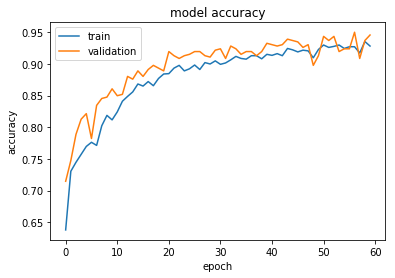

In [191]:
plt.plot(model_trained.history['acc'])
plt.plot(model_trained.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Our Graph looks good, After a good number of epochs our training accuracy started a very little flowing away but our validation accuracy is really good enough to grow.

Now Lets see our training and validation loss history

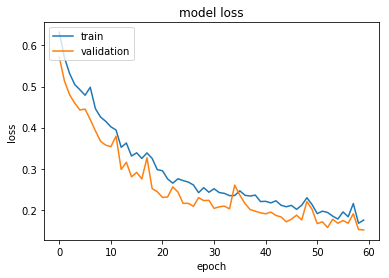

In [192]:
plt.plot(model_trained.history['loss'])
plt.plot(model_trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

As expected, like the accuracy , training loss decremented to certain level and then started a little diverging away, where as our validation loss continued to reach rock bottom.

In [193]:
print("Training loss: {:.2f} / Validation loss: {:.2f}".\
      format(model_trained.history['loss'][-1], model_trained.history['val_loss'][-1]))
print("Training accuracy: {:.2f}% / Validation accuracy: {:.2f}%".\
      format(100*model_trained.history['acc'][-1], 100*model_trained.history['val_acc'][-1]))

Training loss: 0.18 / Validation loss: 0.15
Training accuracy: 92.81% / Validation accuracy: 94.55%


#### Finally Its time for inviting Transfer Learning

Lets define the input layer and its shape to be provided as an input

Lets use VGG16 Pretrained network on Imagenet and reduce a good amount of feature training.(Have tried couple of others but not yielded good result, so came up to vgg16 as a good friend)

In [195]:
img_rows, img_cols, img_channel = 224, 224, 3

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

Lets do the same thing as earlier,

But just a small twist lets make use of our pretrained network before we add our fully connected Dense layers

Initally lets add our VGG16 Pretrained network with the input shape as earlier 224,224,3

Then Lets add three fully connected layer with filters of 256,128,64 with relu as an activation function

For the Final layer lets reduce our filter to 1 and use sigmoid as an activation function.

Once we build our model as above, lets compile our model using the same loss function binary cross entropy, lets optimize with the same Adam-my friend, but lets use parameters using exponential learning rate so that we learn further slowly to understand our features more for better accurate prediction for our metrics accuracy 

In [234]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))

add_model.add(Dense(256, activation='relu'))

add_model.add(Dense(128, activation='relu'))

add_model.add(Dense(64, activation='relu'))

add_model.add(Dense(1, activation='sigmoid'))

vgg16_model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
vgg16_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1E-4),
              metrics=['accuracy'])
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Ohh, Great,

We have got a huge number of parameters but remember we have got our top layers pretrained and usable and now its time
for us to train our model, so this time we further more use ImageDataGenerator function to further better understand
the images by rotating, and training the models at various angles to increase the accuracy.

So, we are now blowing our siren to start the train...no no training...we know the drill right.. lets decide on right
number of epochs(same explanation as above...lol)
Lets have a batch size of 30...and lets see

In [236]:
batch_size = 32
epochs = 20

vgg16_train_datagen = ImageDataGenerator(
        rotation_range=31, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
vgg16_train_datagen.fit(x_train)

vgg16_checkpointer = ModelCheckpoint(filepath='weights.best.vgg16.hdf5', 
                               verbose=1, save_best_only=True)


vgg16_history = vgg16_model.fit_generator(
    vgg16_train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,callbacks=[vgg16_checkpointer],
    validation_data=(x_test, y_test),
)

Epoch 1/20
56/57 [============================>.] - ETA: 0s - loss: 0.0060 - acc: 0.9978
Epoch 00001: val_loss improved from inf to 0.05977, saving model to weights.best.vgg16.hdf5
57/57 [==============================] - 63s 1s/step - loss: 0.0090 - acc: 0.9973 - val_loss: 0.0598 - val_acc: 0.9804
Epoch 2/20
56/57 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9961
Epoch 00002: val_loss did not improve
57/57 [==============================] - 61s 1s/step - loss: 0.0164 - acc: 0.9962 - val_loss: 0.1636 - val_acc: 0.9586
Epoch 3/20
56/57 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9983
Epoch 00003: val_loss improved from 0.05977 to 0.02046, saving model to weights.best.vgg16.hdf5
57/57 [==============================] - 63s 1s/step - loss: 0.0055 - acc: 0.9984 - val_loss: 0.0205 - val_acc: 0.9935
Epoch 4/20
56/57 [============================>.] - ETA: 0s - loss: 3.2836e-04 - acc: 1.0000
Epoch 00004: val_loss did not improve
57/57 [============

Optimizing the model using saved best weights

In [237]:
vgg16_model.load_weights('weights.best.vgg16.hdf5')

Lets again visualize the training history graph for the above training

Lets now observe how our accuracy of training and validation graph by using the history of our model trained above and observe if there are any total discrepencies we can correct.

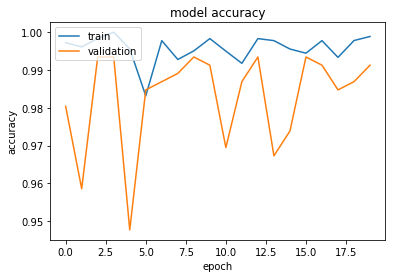

In [238]:
plt.plot(vgg16_history.history['acc'])
plt.plot(vgg16_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

We See the training accuracy is consistent but the validation accuracy is volatile 
and growing slowly then after,we have come with this epochs after observing the stagnancy at 55, 62 etc epochs and found this as a optimal number

Lets see the Loss during training

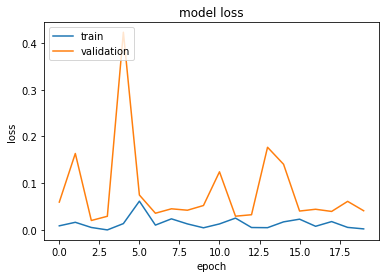

In [239]:
plt.plot(vgg16_history.history['loss'])
plt.plot(vgg16_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Training loss is all the time low and decreasing, but the validation loss has increased and then came back to decrease we preferred to early stop to reduce the overfitting.

Lets normalize the test images like we did for our images before training for consistent result

In [240]:
test_images = test_images.astype('float32')
test_images /= 255

Lets see the loss and accuracy of the overall training and Validation sets

In [241]:
print("Training loss: {:.2f} / Validation loss: {:.2f}".\
      format(history.history['loss'][-1], history.history['val_loss'][-1]))
print("Training accuracy: {:.2f}% / Validation accuracy: {:.2f}%".\
      format(100*history.history['acc'][-1], 100*history.history['val_acc'][-1]))

Training loss: 0.00 / Validation loss: 0.04
Training accuracy: 99.89% / Validation accuracy: 99.13%


We see a Training loss of 0.00 and Validation loss of 0.04 , which are fair enough to be as a good model
Training accuracy of 99.89% yielding a validation accuracy of 99.13% is really good than our own model.

So, Transfer learning made a difference.

Lets now predict the test image labels and store them to submit.csv file as formatted like sample_submission and lets see our board rank

In [243]:
predictions = vgg16_model.predict(test_images)
for i, name in enumerate(test_names):
    sample_submission.loc[sample_submission['name'] == name, 'invasive'] = predictions[i]

sample_submission.to_csv("submit.csv", index=False)

This has yielded a test score of 0.5000 which got us 483/513 position on leaderboard for the first submission,lets give one more try using different pretrained model.The Benchmark model was 0.997 and our attempt was to reasonably give a good attempt on my first kaggle competition.
Hopfully would take a part in the next competitions to increased the accuracy on test by using the gained knowledge.

Finally,

During the process, When creating a model of own , the training was struck at a point when i used various optimizers such as rmsprop and took me hell lot of time to figure out where the problem is....and the second place is the tuning, i have had a difficulty to tune once the model was setup specially at a cost of gpu and cpu speed.
I was unable to build the model on my system and couldnt get a right online cloud platform and the documentation on aws was removed from udacity and no peer environment related to machine learning, this has taken a lot of time, finally because of this, now i am capable enough to train models on three big cloud platforms, AWS, Google, FLoyd..lol...for a good cause.

The best part during the model training is that i was surprised to see a huge difference when i have changed the optimizer to Adam, which literally made me see progress and happiness in my eyes..and Transfer learning also made a difference.